# Random Forest pour la prediction de la consommation d'énergie 


# Importation 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")
%matplotlib inline
import joblib

# Chargement et Nettoyage des données

In [13]:
# 1. Chargement des données
df = pd.read_csv('morocco.csv')

In [15]:
# 2. Nettoyage des noms de colonnes (suppression des espaces inutiles)
df.columns = df.columns.str.strip()

Feature Engineering

In [16]:
# 3. Conversion de la colonne DateTime
# 'dayfirst=True' est important pour le format JJ/MM/AAAA
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True, errors='coerce')

# Suppression des lignes où la date n'a pas pu être lue (erreurs de format)
df = df.dropna(subset=['DateTime'])
df = df.sort_values('DateTime')

In [17]:
# 4. Gestion des valeurs manquantes (NaN)
# Pour des séries temporelles (énergie), l'interpolation linéaire est mieux que la moyenne
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

In [49]:
# Création de la variable cible "Consommation Totale"
# On additionne les 3 zones pour avoir la demande globale du pays/région
df['Total_Consumption'] = df['Zone 1'] + df['Zone 2'] + df['Zone 3']

print("Aperçu des données nettoyées :")
display(df.head(10))
print("\nInfos manquantes après nettoyage :")
print(df.isnull().sum())

Aperçu des données nettoyées :


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3,Total_Consumption,Hour,Month,DayOfWeek,Day,Load_Category
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544,0,1,6,1,Moyen
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,69320.84387,0,1,6,1,Moyen
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,67803.22193,0,1,6,1,Moyen
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,65489.23209,0,1,6,1,Moyen
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,63650.44627,0,1,6,1,Moyen
5,2017-01-01 00:50:00,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048,62171.34398,0,1,6,1,Moyen
6,2017-01-01 01:00:00,5.641,77.7,0.080,0.048,0.096,25998.98734,16993.31307,17945.06024,60937.36065,1,1,6,1,Faible
7,2017-01-01 01:10:00,5.496,78.2,0.085,0.055,0.093,25446.07595,16661.39818,17459.27711,59566.75124,1,1,6,1,Faible
8,2017-01-01 01:20:00,5.678,78.1,0.081,0.066,0.141,24777.72152,16227.35562,17025.54217,58030.61931,1,1,6,1,Faible
9,2017-01-01 01:30:00,5.491,77.3,0.082,0.062,0.111,24279.49367,15939.20973,16794.21687,57012.92027,1,1,6,1,Faible



Infos manquantes après nettoyage :
DateTime                 0
Temperature              0
Humidity                 0
Wind Speed               0
general diffuse flows    0
diffuse flows            0
Zone 1                   0
Zone 2                   0
Zone 3                   0
Total_Consumption        0
Hour                     0
Month                    0
DayOfWeek                0
Day                      0
Load_Category            0
dtype: int64


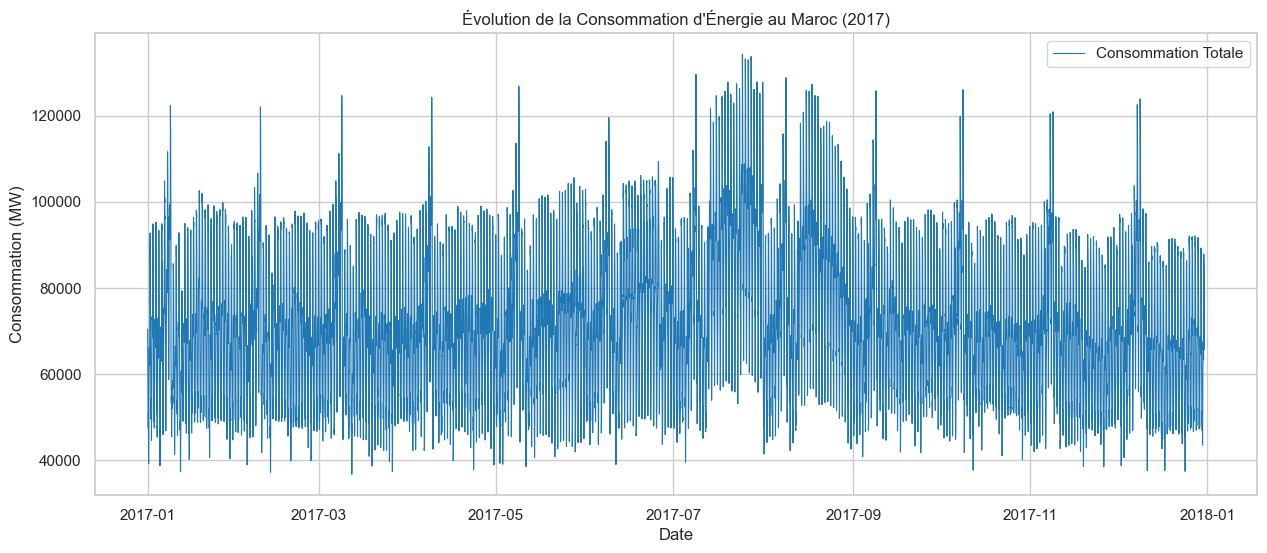

In [19]:
# Graphique 1 : Consommation au fil du temps
plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['Total_Consumption'], label='Consommation Totale', color='#1f77b4', linewidth=0.8)
plt.title("Évolution de la Consommation d'Énergie au Maroc (2017)")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.show()

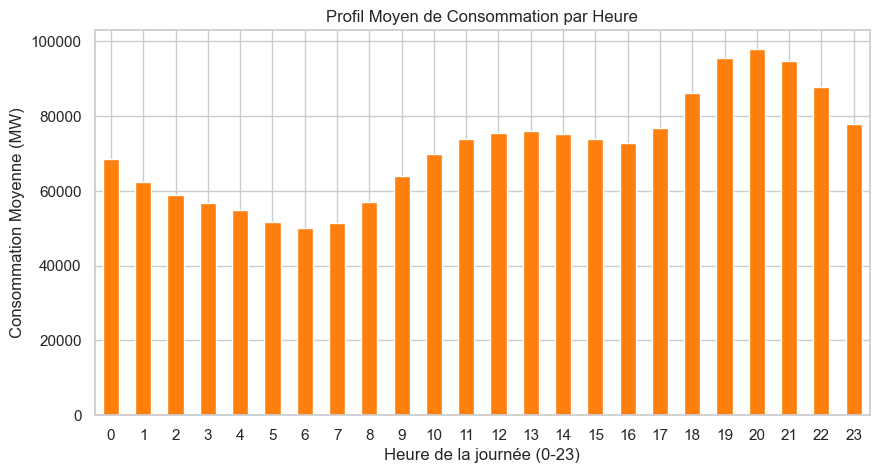

In [20]:
# Graphique 2 : Profil moyen par heure (Pour comprendre les pics)
df['Hour'] = df['DateTime'].dt.hour
hourly_avg = df.groupby('Hour')['Total_Consumption'].mean()

plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar', color='#ff7f0e')
plt.title("Profil Moyen de Consommation par Heure")
plt.xlabel("Heure de la journée (0-23)")
plt.ylabel("Consommation Moyenne (MW)")
plt.xticks(rotation=0)
plt.show()

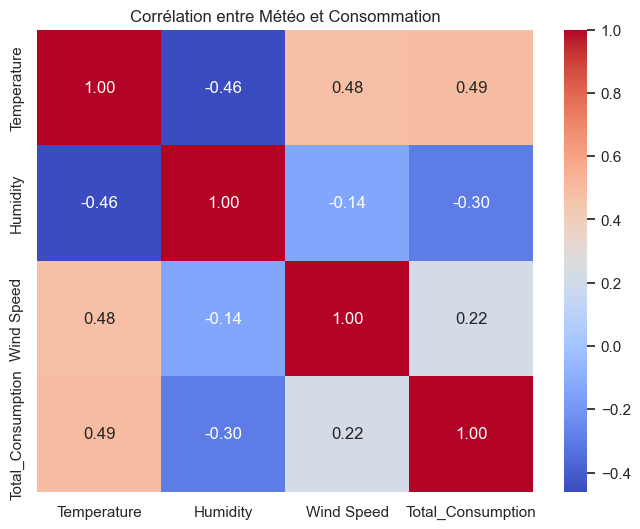

In [21]:
# Graphique 3 : Matrice de Corrélation
# On regarde ce qui influence le plus la consommation (Température ? Vent ?)
corr_cols = ['Temperature', 'Humidity', 'Wind Speed', 'Total_Consumption']
plt.figure(figsize=(8, 6))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre Météo et Consommation")
plt.show()

In [22]:
# Extraction des caractéristiques temporelles
df['Month'] = df['DateTime'].dt.month
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df['Day'] = df['DateTime'].dt.day

In [23]:
# Sélection des features (X) et de la cible (y)
features = ['Temperature', 'Humidity', 'Wind Speed', 'Hour', 'Month', 'DayOfWeek', 'general diffuse flows', 'diffuse flows']
target = 'Total_Consumption'

X = df[features]
y = df[target]

In [24]:
# Séparation Train / Test
# IMPORTANT : Pour des séries temporelles, on ne mélange pas aléatoirement (shuffle=False).
# On s'entraîne sur le passé (80%) pour prédire le futur (20%).
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Données d'entraînement : {X_train.shape}")
print(f"Données de test : {X_test.shape}")

Données d'entraînement : (41932, 8)
Données de test : (10484, 8)


In [25]:
# Choix du modèle : Random Forest Regressor
# (Robuste, gère bien les relations non-linéaires comme la météo et l'heure)
regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Entraînement du modèle de régression en cours...")
regressor.fit(X_train, y_train)

Entraînement du modèle de régression en cours...


RandomForestRegressor(n_jobs=-1, random_state=42)

In [26]:
# Prédiction
y_pred = regressor.predict(X_test)

In [27]:
# Évaluation des performances
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n--- Performance du Modèle (Régression) ---")
print(f"RMSE (Erreur Moyenne) : {rmse:.2f} MW")
print(f"R² Score (Précision)  : {r2:.2f} (1.00 est parfait)")


--- Performance du Modèle (Régression) ---
RMSE (Erreur Moyenne) : 5107.44 MW
R² Score (Précision)  : 0.89 (1.00 est parfait)


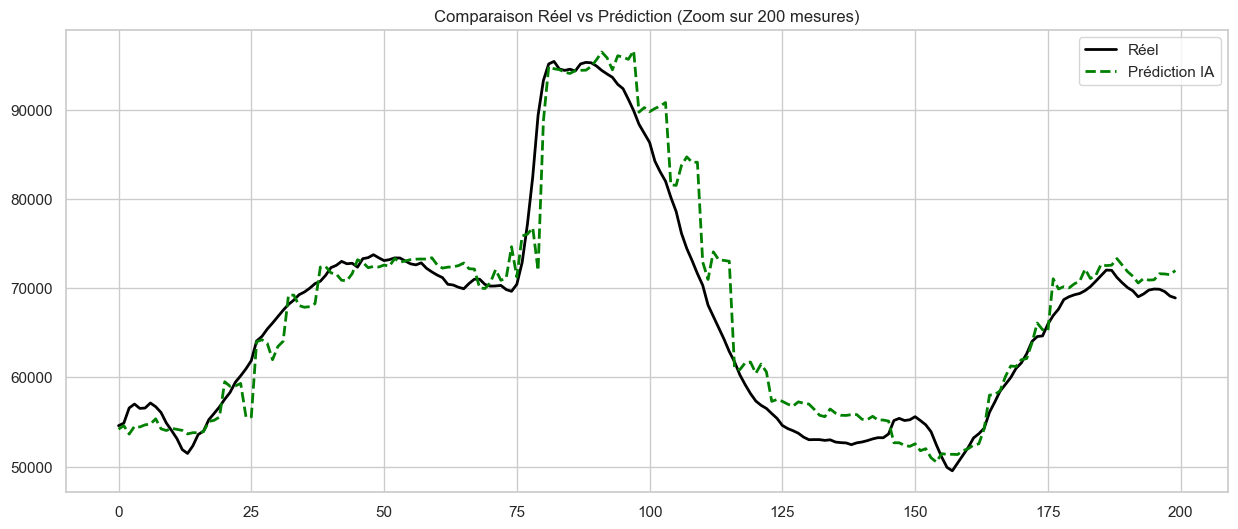

In [28]:
# Visualisation des résultats (Zoom sur 200 points pour y voir clair)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:200], label='Réel', color='black', linewidth=2)
plt.plot(y_pred[:200], label='Prédiction IA', color='green', linestyle='--', linewidth=2)
plt.title("Comparaison Réel vs Prédiction (Zoom sur 200 mesures)")
plt.legend()
plt.show()

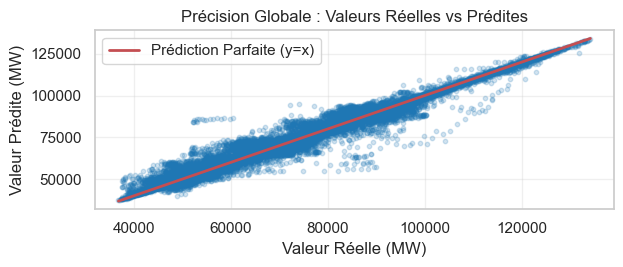

In [46]:
# GRAPHIQUE 2 : Scatter Plot (Nuage de points)
# Plus les points sont proches de la ligne rouge, meilleur est le modèle
plt.subplot(2, 1, 2)
plt.scatter(y_reel, y_pred, alpha=0.2, color='#1f77b4', s=10)
# Ligne de perfection
p1 = max(max(y_pred), max(y_reel))
p2 = min(min(y_pred), min(y_reel))
plt.plot([p1, p2], [p1, p2], 'r-', label='Prédiction Parfaite (y=x)', linewidth=2)
plt.title("Précision Globale : Valeurs Réelles vs Prédites")
plt.xlabel("Valeur Réelle (MW)")
plt.ylabel("Valeur Prédite (MW)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Création des classes : Faible, Moyen, Élevé (basé sur les quartiles)
labels = ['Faible', 'Moyen', 'Élevé']
df['Load_Category'] = pd.qcut(df['Total_Consumption'], q=3, labels=labels)

y_class = df['Load_Category']
y_class_train, y_class_test = y_class.iloc[:split_index], y_class.iloc[split_index:]

In [30]:
# Entraînement du Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_class_train)
y_class_pred = clf.predict(X_test)

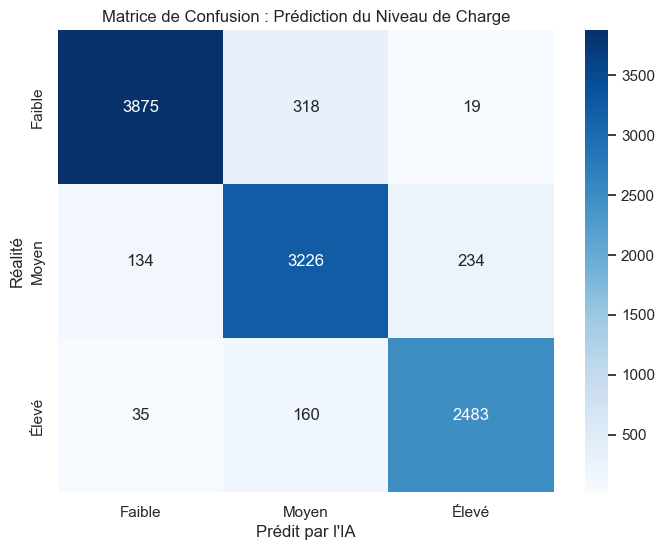


Rapport de Classification :
              precision    recall  f1-score   support

      Faible       0.96      0.92      0.94      4212
       Moyen       0.87      0.90      0.88      3594
       Élevé       0.91      0.93      0.92      2678

    accuracy                           0.91     10484
   macro avg       0.91      0.91      0.91     10484
weighted avg       0.92      0.91      0.91     10484



In [31]:
# Matrice de confusion
cm = confusion_matrix(y_class_test, y_class_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matrice de Confusion : Prédiction du Niveau de Charge")
plt.xlabel("Prédit par l'IA")
plt.ylabel("Réalité")
plt.show()

print("\nRapport de Classification :")
print(classification_report(y_class_test, y_class_pred))

# TEST DU MODÈLE

In [32]:
# On va créer deux scénarios fictifs pour voir comment le modèle réagit.

# Scénario 1 : Une après-midi caniculaire en Juillet (Besoin de climatisation ?)
# Temp: 35°C, Humidité: 40%, 14h00, Mois 7 (Juillet), Mercredi
scenario_ete = {
    'Temperature': 35.0,
    'Humidity': 40.0,
    'Wind Speed': 5.0,
    'Hour': 14,
    'Month': 7,
    'DayOfWeek': 2, # Mercredi
    'general diffuse flows': 0.8, # Ensoleillé
    'diffuse flows': 0.5
}

# Scénario 2 : Une soirée froide d'Hiver (Besoin de chauffage ?)
# Temp: 5°C, Humidité: 80%, 20h00, Mois 1 (Janvier), Samedi
scenario_hiver = {
    'Temperature': 5.0,
    'Humidity': 80.0,
    'Wind Speed': 10.0,
    'Hour': 20,
    'Month': 1,
    'DayOfWeek': 5, # Samedi
    'general diffuse flows': 0.0, # Nuit (pas de solaire)
    'diffuse flows': 0.0
}

In [33]:
# Création d'un DataFrame avec ces 2 scénarios
# (Il faut respecter l'ordre exact des colonnes utilisées lors de l'entraînement)
features_order = ['Temperature', 'Humidity', 'Wind Speed', 'Hour', 'Month', 'DayOfWeek', 'general diffuse flows', 'diffuse flows']
nouveaux_cas = pd.DataFrame([scenario_ete, scenario_hiver], columns=features_order)

print("Scénarios à tester :")
display(nouveaux_cas)


Scénarios à tester :


,Temperature,Humidity,Wind Speed,Hour,Month,DayOfWeek,general diffuse flows,diffuse flows
0,35.0,40.0,5.0,14,7,2,0.8,0.5
1,5.0,80.0,10.0,20,1,5,0.0,0.0


In [34]:
# Prédiction
predictions = regressor.predict(nouveaux_cas)

print("\n--- RÉSULTATS DES PRÉVISIONS ---")
print(f"Scénario 1 (Été 14h, 35°C) : La demande prévue est de {predictions[0]:.2f} MW")
print(f"Scénario 2 (Hiver 20h, 5°C) : La demande prévue est de {predictions[1]:.2f} MW")


--- RÉSULTATS DES PRÉVISIONS ---
Scénario 1 (Été 14h, 35°C) : La demande prévue est de 96771.54 MW
Scénario 2 (Hiver 20h, 5°C) : La demande prévue est de 95095.62 MW


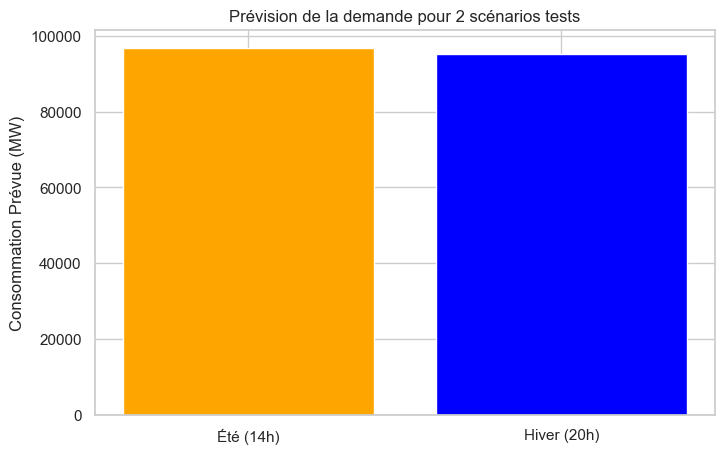

In [35]:
#Comparaison visuelle
plt.figure(figsize=(8, 5))
plt.bar(['Été (14h)', 'Hiver (20h)'], predictions, color=['orange', 'blue'])
plt.ylabel("Consommation Prévue (MW)")
plt.title("Prévision de la demande pour 2 scénarios tests")
plt.show()

les graphes montrent une consommation plus élevée pour le scénario d'hiver le soir (90 000 MW), pour l'après-midi d'été,ce qui est cohérent avec les pics de chauffage/éclairage en soirée.

In [36]:
# Test de sensibilité à la chaleur (Est-ce que la clim joue ?)
# On compare deux journées d'été à la MEME heure (14h)

# Cas 1 : Canicule (Votre scénario actuel)
ete_chaud = [35.0, 40.0, 5.0, 14, 7, 2, 0.8, 0.5] 

# Cas 2 : Été frais (Orage d'été par exemple, seulement 20°C)
ete_frais = [20.0, 40.0, 5.0, 14, 7, 2, 0.8, 0.5]

# Création du DataFrame
test_clim = pd.DataFrame([ete_chaud, ete_frais], 
                         columns=['Temperature', 'Humidity', 'Wind Speed', 'Hour', 'Month', 'DayOfWeek', 'general diffuse flows', 'diffuse flows'])


In [37]:

preds_clim = regressor.predict(test_clim)

print(f"Été Chaud (35°C) : {preds_clim[0]:.2f} MW")
print(f"Été Frais (20°C) : {preds_clim[1]:.2f} MW")

diff = preds_clim[0] - preds_clim[1]
print(f"Impact de la chaleur (Climatisation estimée) : +{diff:.2f} MW")

Été Chaud (35°C) : 96771.54 MW
Été Frais (20°C) : 73782.68 MW
Impact de la chaleur (Climatisation estimée) : +22988.85 MW


le résultat "Été Chaud" est supérieur à "Été Frais", notre scénario est excellent : le modèle  a bien appris la relation "Chaleur = Plus d'électricité".

# Sauvegarde du modèle entraîné


In [39]:
# On enregistre l'objet 'regressor' dans un fichier
filename = 'model_consommation_maroc.pkl'
joblib.dump(regressor, filename)

print(f" Modèle sauvegardé sous le nom : {filename}")

# 2. (Optionnel mais recommandé) Sauvegarder l'ordre des colonnes
# C'est CRUCIAL pour Flask : il faut envoyer les données dans le même ordre exact.
cols_filename = 'model_columns.pkl'
joblib.dump(features, cols_filename)
print(f"Liste des colonnes sauvegardée sous : {cols_filename}")

 Modèle sauvegardé sous le nom : model_consommation_maroc.pkl
Liste des colonnes sauvegardée sous : model_columns.pkl
